### 随机森林（Random Forest）算法详解


#### 一、核心概念  
随机森林是一种**集成学习算法**，通过构建多个决策树并综合其结果来提高预测性能。其核心思想是：**“三个臭皮匠顶个诸葛亮”**，即通过多个弱分类器（决策树）的集体决策，降低单一模型的过拟合风险，提升泛化能力。  

- **关键术语**：  
  - **决策树**：基础模型，通过特征分裂递归构建的树状结构；  
  - **Bagging（ bootstrap aggregating ）**：对训练集进行有放回抽样（bootstrap），为每个决策树生成不同的训练子集；  
  - **特征随机选择**：每个决策树分裂时，仅从随机选择的部分特征中寻找最优分裂点；  
  - **投票/平均**：分类任务取多数决策树的预测结果，回归任务取预测结果的平均值。  


#### 二、核心原理  
随机森林的工作流程分为**训练**和**预测**两个阶段：  

1. **训练阶段**：  
   - 对原始训练集进行`n_estimators`次有放回抽样（bootstrap），生成`n_estimators`个不同的训练子集；  
   - 为每个训练子集构建一棵决策树：  
     - 树的每个节点分裂时，从全部特征中随机选择`max_features`个特征；  
     - 从选中的特征中寻找最优分裂点（如信息增益最大）；  
     - 树不进行剪枝，保持最大复杂度；  
   - 最终得到由`n_estimators`棵决策树组成的“森林”。  

2. **预测阶段**：  
   - 分类任务：所有决策树投票，得票最多的类别为最终结果；  
   - 回归任务：所有决策树的预测值取平均，作为最终结果。  


#### 三、超参数影响  
- **`n_estimators`**：决策树数量（默认100）。数量过少易欠拟合，过多会增加计算量（通常100-500为宜）；  
- **`max_features`**：每棵树可使用的最大特征数（分类默认`sqrt(n_features)`，回归默认`n_features`）。值越小随机性越强，过拟合风险越低，但可能丢失重要特征；  
- **`max_depth`**：树的最大深度（默认None，即不限制）。过深易过拟合，需适当限制；  
- **`min_samples_split`**：节点分裂所需的最小样本数（默认2）。值越大，树越简单，抗过拟合能力越强。  


#### 四、适用场景与优缺点  
- **适用场景**：  
  - 分类任务（如信用评分、疾病预测）；  
  - 回归任务（如房价预测、销量预测）；  
  - 特征重要性评估（随机森林可量化特征对预测的贡献）；  
  - 处理高维数据和缺失值（无需复杂预处理）。  

- **优点**：  
  1. 准确率高，泛化能力强，不易过拟合；  
  2. 能处理高维数据，无需特征选择；  
  3. 可输出特征重要性，便于模型解释；  
  4. 对缺失值和异常值不敏感。  

- **缺点**：  
  1. 计算复杂度高，训练时间长（尤其树数量多的时候）；  
  2. 模型结构复杂，解释性不如单一决策树；  
  3. 对噪声过多的数据集表现较差。  


#### 五、代码实例（2个独立Python文件）  

##### 1. 简洁版：sklearn实现随机森林（分类与回归）  

=== 随机森林分类评估 ===
准确率：0.8889

分类报告：
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.78      0.93      0.85        15
   virginica       0.92      0.73      0.81        15

    accuracy                           0.89        45
   macro avg       0.90      0.89      0.89        45
weighted avg       0.90      0.89      0.89        45



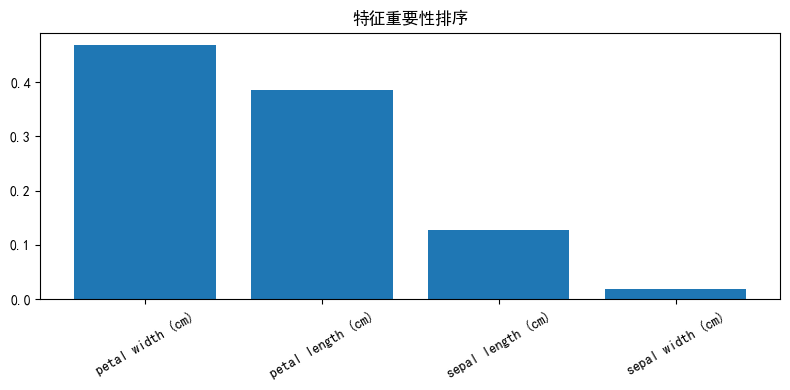

In [2]:
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.metrics import classification_report

# 解决中文显示问题
matplotlib.rcParams["font.family"] = ["SimHei", "Microsoft YaHei"]
matplotlib.rcParams["axes.unicode_minus"] = False

# 1. 随机森林分类（鸢尾花数据集）
def random_forest_classification():
    # 加载数据
    iris = datasets.load_iris()
    x = iris.data
    y = iris.target
    class_names = iris.target_names

    # 划分数据集
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)

    # 训练随机森林分类器
    rf_clf = RandomForestClassifier(
        n_estimators=50,  # 50棵树
        max_depth=5,      # 限制树深度防过拟合
        max_features='sqrt',  # 每棵树用sqrt(n_features)个特征
        random_state=42
    )
    rf_clf.fit(x_train, y_train)

    # 评估
    y_pred = rf_clf.predict(x_test)
    print("=== 随机森林分类评估 ===")
    print(f"准确率：{accuracy_score(y_test, y_pred):.4f}")
    print("\n分类报告：")

    # 打印分类报告，用于详细评估分类模型的性能
    # classification_report 函数会输出每个类别的精确率、召回率、F1分数和支持样本数
    # target_names 是每个类别的名称，用于在报告中显示对应的类别标签
    print(classification_report(y_test, y_pred, target_names=class_names))


    # 特征重要性可视化
    # feature_importances_ 属性返回一个数组，数组中的每个元素对应一个特征的重要性
    importances = rf_clf.feature_importances_

    features = iris.feature_names
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(8, 4))

    # 绘制柱状图展示特征重要性，x轴为特征序号，y轴为对应特征的重要性得分
    # range(len(importances)) 生成特征序号，importances[indices] 按重要性降序排列后的特征重要性得分
    plt.bar(range(len(importances)), importances[indices])

    # range(len(importances)) 设置x轴刻度标签，[features[i] for i in indices] 按重要性降序排列后的特征名
    # 称,rotation=30将标签旋转30度，避免标签之间重叠
    plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=30)

    plt.title("特征重要性排序")
    plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域，避免图表元素（如坐标轴标签、标题等）相互重叠
    plt.show()

random_forest_classification()


=== 随机森林回归评估 ===
MSE（均方误差）：0.3314
R²（决定系数）：0.7475


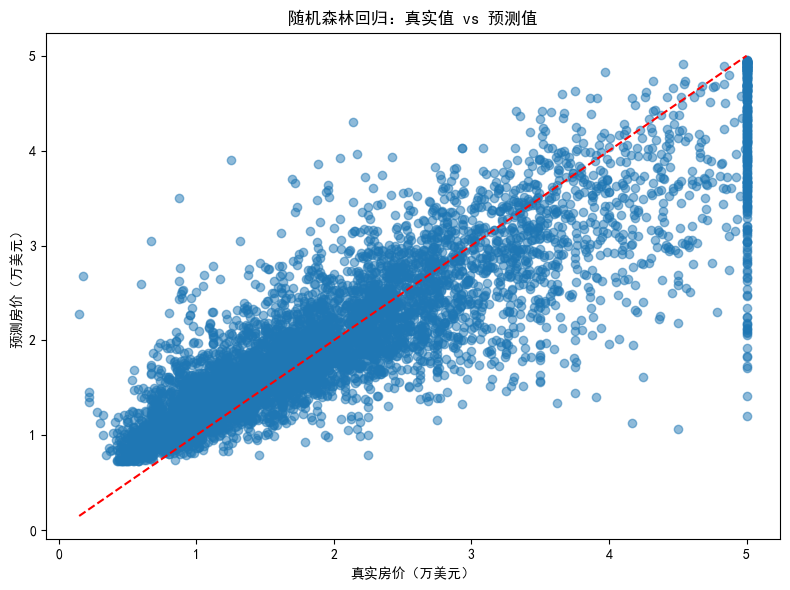

In [3]:
# 2. 随机森林回归（房价数据集）
def random_forest_regression():
    # 加载数据（加利福尼亚房价）
    california = datasets.fetch_california_housing()
    x = california.data
    y = california.target

    # 划分数据集
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.3, random_state=42
    )

    # 训练随机森林回归器
    rf_reg = RandomForestRegressor(
        n_estimators=50,
        max_depth=8,
        max_features='log2',  # 每棵树用log2(n_features)个特征
        random_state=42
    )
    rf_reg.fit(x_train, y_train)

    # 评估
    y_pred = rf_reg.predict(x_test)
    print("\n=== 随机森林回归评估 ===")
    print(f"MSE（均方误差）：{mean_squared_error(y_test, y_pred):.4f}")
    print(f"R²（决定系数）：{r2_score(y_test, y_pred):.4f}")

    # 真实值 vs 预测值可视化
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # 画理想线
    plt.xlabel("真实房价（万美元）")
    plt.ylabel("预测房价（万美元）")
    plt.title("随机森林回归：真实值 vs 预测值")
    plt.tight_layout()
    plt.show()

random_forest_regression()

##### 2. 全面版：sklearn实现（参数调优+性能对比）  

=== 随机森林分类参数调优 ===
分类任务最优参数： {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 50}
最优交叉验证F1：0.9741

测试集评估：
准确率：0.9474
F1分数：0.9585
AUC：0.9893

单棵决策树准确率：0.9298
随机森林准确率提升：0.0175


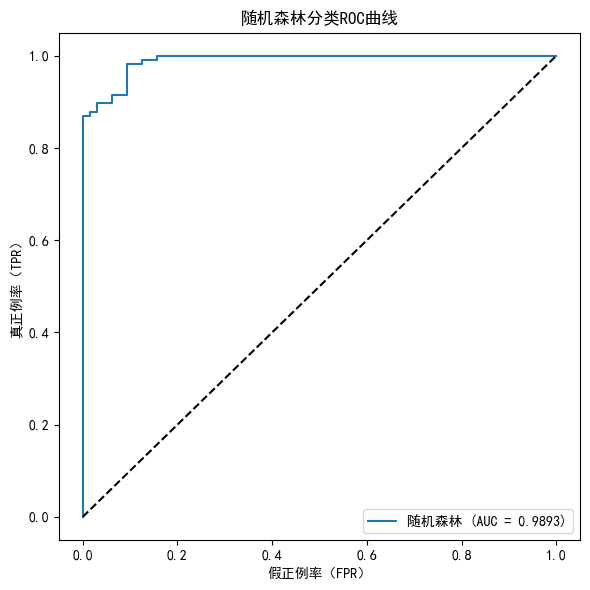

In [1]:
from sklearn.datasets import load_breast_cancer, fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, roc_curve,mean_squared_error, r2_score)
import matplotlib.pyplot as plt
import matplotlib
import os
import numpy as np

os.environ["LOKY_MAx_CPU_COUNT"] = "4"  # 解决CPU核心数检测警告

# 解决中文显示问题
matplotlib.rcParams["font.family"] = ["SimHei", "Microsoft YaHei"]
matplotlib.rcParams["axes.unicode_minus"] = False

# 1. 随机森林分类调优（乳腺癌数据集）
def rf_classification_tuning():
    data = load_breast_cancer()
    x, y = data.data, data.target
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)

    # 定义用于网格搜索的参数网格，通过尝试不同的参数组合来找到最优模型
    param_grid = {

        # 决策树的数量，尝试使用50棵和100棵树进行训练
        'n_estimators': [50, 100],

        # 决策树的最大深度，尝试限制树的深度为5层、10层，或者不限制深度（None）
        'max_depth': [5, 10, None],

        # 每棵树在分裂节点时可考虑的最大特征数，'sqrt'表示取特征数量的平方根，'log2'表示取特征数量的对数
        'max_features': ['sqrt', 'log2'],

        # 节点分裂所需的最小样本数，尝试当节点样本数达到2个或5个时进行分裂
        'min_samples_split': [2, 5]
    }

    # 使用GridSearchCV进行网格搜索，通过遍历指定参数组合来找到最优模型
    grid_search = GridSearchCV(

        # 定义要调优的模型为随机森林分类器，设置随机种子保证结果可复现
        RandomForestClassifier(random_state=42),

        # 传入参数网格，GridSearchCV会尝试param_grid中的所有参数组合
        param_grid,

        # 进行3折交叉验证，将训练数据划分为3份，轮流使用其中2份训练，1份验证
        cv=3,

        # 使用F1分数作为评估指标，F1分数综合考虑了精确率和召回率
        scoring='f1',

        # 使用所有可用的CPU核心并行计算，加快网格搜索的速度
        n_jobs=-1,

        # 不输出详细的搜索日志，保持运行过程的简洁
        verbose=0  # 不输出详细日志
    )

    grid_search.fit(x_train, y_train)

    print("分类任务最优参数：", grid_search.best_params_)
    print(f"最优交叉验证F1：{grid_search.best_score_:.4f}")

    # 最佳模型评估
    # best_estimator_ 是 GridSearchCV 类的一个属性，在使用 GridSearchCV 进行超参数调优时，该属性会返回在交叉验证过程中表现最优的估计器（模型）。
    best_clf = grid_search.best_estimator_

    y_pred = best_clf.predict(x_test)

    # 使用最佳分类器预测测试集样本属于正类（类别1）的概率
    # predict_proba 方法返回一个二维数组，每行对应一个样本，每列对应一个类别的概率
    # [:, 1] 表示取所有样本的第二个列（索引为1），即正类的概率
    y_pred_proba = best_clf.predict_proba(x_test)[:, 1]

    print("\n测试集评估：")
    print(f"准确率：{accuracy_score(y_test, y_pred):.4f}")
    print(f"F1分数：{f1_score(y_test, y_pred):.4f}")
    print(f"AUC：{roc_auc_score(y_test, y_pred_proba):.4f}")

    # 与单棵决策树对比
    dt_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
    dt_clf.fit(x_train, y_train)
    dt_acc = accuracy_score(y_test, dt_clf.predict(x_test))
    print(f"\n单棵决策树准确率：{dt_acc:.4f}")
    print(f"随机森林准确率提升：{(accuracy_score(y_test, y_pred) - dt_acc):.4f}")

    # 绘制ROC曲线
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"随机森林 (AUC = {roc_auc_score(y_test, y_pred_proba):.4f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("假正例率（FPR）")
    plt.ylabel("真正例率（TPR）")
    plt.title("随机森林分类ROC曲线")
    plt.legend()
    plt.tight_layout()
    plt.show()

print("=== 随机森林分类参数调优 ===")
rf_classification_tuning()


=== 随机森林回归参数调优 ===

回归任务最优参数： {'max_depth': None, 'max_features': 'log2', 'n_estimators': 100}
最优交叉验证MSE：0.2594

测试集评估：
MSE：0.2424
R²：0.8153
indices: 
[0 5 6 7 2 1 3 4]



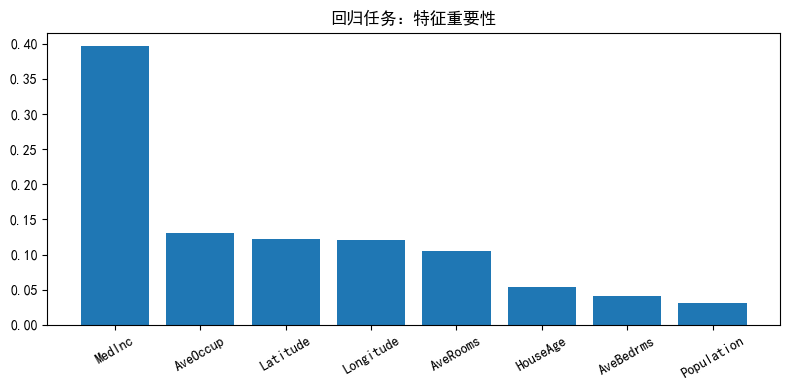

In [4]:
# 2. 随机森林回归调优（房价数据集）
def rf_regression_tuning():
    data = fetch_california_housing()
    x, y = data.data, data.target
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.3, random_state=42
    )

    # 参数网格
    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [8, 15, None],
        'max_features': ['sqrt', 'log2']
    }

    # 网格搜索
    grid_search = GridSearchCV(
        RandomForestRegressor(random_state=42),
        param_grid,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=0
    )
    grid_search.fit(x_train, y_train)

    print("\n回归任务最优参数：", grid_search.best_params_)
    print(f"最优交叉验证MSE：{-grid_search.best_score_:.4f}")

    # 最佳模型评估
    best_reg = grid_search.best_estimator_
    y_pred = best_reg.predict(x_test)
    print("\n测试集评估：")
    print(f"MSE：{mean_squared_error(y_test, y_pred):.4f}")
    print(f"R²：{r2_score(y_test, y_pred):.4f}")

    # 特征重要性可视化
    # 从最佳回归模型中获取每个特征的重要性得分
    # feature_importances_ 属性返回一个数组，数组中的每个元素对应一个特征的重要性
    importances = best_reg.feature_importances_

    indices = np.argsort(importances)[::-1]  # 按重要性降序排列特征索引, 然后取反, 得到降序排列的特征索引,且importances索引和feature_names索引相同)
    print(f"indices: \n{indices}\n")

    feature_names = data.feature_names

    plt.figure(figsize=(8, 4))
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=30)
    plt.title("回归任务：特征重要性")
    plt.tight_layout()
    plt.show()

print("\n=== 随机森林回归参数调优 ===")
rf_regression_tuning()


=== 树数量影响分析 ===


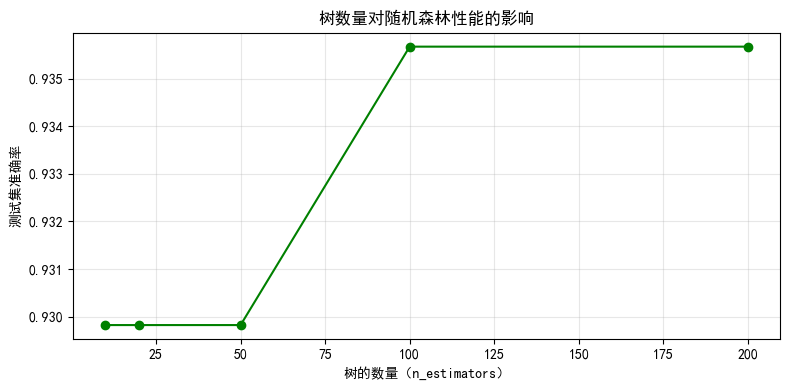

In [6]:
# 3. 不同树数量对性能的影响
def plot_n_estimators_influence():
    data = load_breast_cancer()
    x, y = data.data, data.target
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.3, random_state=42, stratify=y
    )

    # 测试不同树数量
    n_estimators_list = [10, 20, 50, 100, 200]
    accuracies = []
    for n in n_estimators_list:
        clf = RandomForestClassifier(
            n_estimators=n, max_depth=8, random_state=42
        )
        clf.fit(x_train, y_train)
        accuracies.append(accuracy_score(y_test, clf.predict(x_test)))

    # 绘图
    plt.figure(figsize=(8, 4))
    plt.plot(n_estimators_list, accuracies, 'o-', color='g')
    plt.xlabel("树的数量（n_estimators）")
    plt.ylabel("测试集准确率")
    plt.title("树数量对随机森林性能的影响")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

print("\n=== 树数量影响分析 ===")
plot_n_estimators_influence()


### 总结  
随机森林是工业界最常用的算法之一，凭借高准确率和强鲁棒性成为许多任务的“ baseline ”模型。实践中需注意：
1.重点调整:`n_estimators`（树数量）、`max_depth`（树深度）和`max_features`（特征采样数），平衡性能与效率；
2.特征重要性：利用随机森林的`feature_importances_`可快速识别关键特征，辅助特征工程；
3.OOB评估：无需额外划分验证集，利用袋外样本评估模型，尤其适合小数据集；
4.效率优化：大数据集可减少`n_estimators`或限制`max_depth`，或使用`n_jobs=-1`并行训练。
